In [1]:
# test
#a_0 = tf.constant([[1, 2, 1], [3,4,3]],dtype = 'float32')
#w_0 = tf.constant([[5, 6, 20, 19], [7, 8, 40, 60], [7, 8, 93, 95]],dtype = 'float32')

#with tf.Session() as sess:
#    print(tf.matmul(a_0, w_0).eval())
#    print(tf.reduce_mean(tf.matmul(a_0, w_0), 0).eval())
#    print(sess.run(tf.reduce_sum(tf.log(tf.reduce_mean(tf.matmul(a_0, w_0), 0)))))

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

In [3]:
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

    return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data
ed.set_seed(42)

x_train = build_toy_dataset(N)

In [4]:
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [5]:
T = 300  # number of MCMC samples
qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [6]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize(n_print=100)

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  1/200 [  0%]                                ETA: 136s | Acceptance Rate: nan
Inferred cluster means:
[[-0.1476999  -0.15256745]
 [-0.5213311   0.6480533 ]]
  4/200 [  2%]                                ETA: 37s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.19423132 -0.18093492]
 [ 0.68906355  0.5670423 ]]
  6/200 [  3%]                                ETA: 25s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.23632054 -0.23158836]
 [ 0.89903337  0.77157545]]
  8/200 [  4%] █                              ETA: 19s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.37384012 -0.35817894]
 [ 0.9234627   0.8505279 ]]
 10/200 [  5%] █                              ETA: 15s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.5094319  -0.4917584 ]
 [ 0.9386744   0.89119315]]
 12/200 [  6%] █                              ETA: 13s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.6075479  -0.57490504]
 [ 0.9464375   0.91503423]]
 14/200 [  7%] ██                             E

106/200 [ 53%] ███████████████                ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9690432  -0.92867917]
 [ 0.98166656  1.0127912 ]]
108/200 [ 54%] ████████████████               ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9699521  -0.92920053]
 [ 0.9820818   1.0130548 ]]
110/200 [ 55%] ████████████████               ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9707948 -0.9297813]
 [ 0.9820432  1.0129721]]
112/200 [ 56%] ████████████████               ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9713117 -0.9302508]
 [ 0.9824971  1.012788 ]]
114/200 [ 56%] █████████████████              ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9721706  -0.93105716]
 [ 0.98266816  1.0131452 ]]
116/200 [ 57%] █████████████████              ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9729572 -0.9314077]
 [ 0.9829023  1.0132784]]
118/200 [ 59%] █████████████████              ETA: 1s | Acceptan

In [7]:
M = 100
mu_sample = qmu.sample(M) #(sample size, K, D)
sigmasq_sample = qsigmasq.sample(M)
pi_sample = qpi.sample(M)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))   #(T, sample size, K, D)
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, M, K, 1])  

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [8]:
clusters = tf.argmax(log_liks, 1).eval()

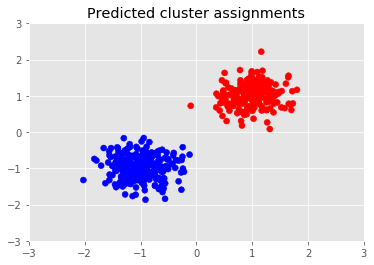

In [9]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [10]:
#M = 100
 # (100 * K)

In [12]:
log_liks_3 = x_post.log_prob(x_broadcasted)
log_liks_3 = tf.reduce_sum(log_liks_3, 3) #[N, M, K]
pi_samples_tiled_3 = tf.tile(tf.expand_dims(tf.log(pi_sample), 0), [N, 1,1]) # [500, 100, 7], [N, M, K]
sum_log_pi_normal_3 = tf.add(pi_samples_tiled_3,log_liks_3) # [500, 100, 7]
x_max_3 = tf.reduce_max(sum_log_pi_normal_3, axis=2) # [500, 100]
edited_log_sum_3 = tf.add(x_max_3, tf.log(tf.reduce_sum(tf.exp(sum_log_pi_normal_3 - tf.expand_dims(x_max_3, 2)), axis=2))) #[500, 100]

### Posterior Dispersion Index

In [13]:
#log_liks2 = x_post.log_prob(x_broadcasted) 

In [14]:
#log_liks2 = tf.reduce_sum(log_liks2, 3)

In [15]:
#pi_samples_tiled = tf.tile(tf.expand_dims(tf.transpose(pi_sample), 0), [N, 1,1]) # [500, 7, 100], [N, K, M]

### PDI definition

In [16]:
#p_x_given_theta = tf.matmul(tf.exp(log_liks2), pi_samples_tiled) #[N, ?, ?] in this case is different pi and (mu, sigma) combo
#p_x_given_theta = tf.reshape(p_x_given_theta, [N, -1]) # [N, ? * ?]

In [17]:
#mean, variance = tf.nn.moments(p_x_given_theta, axes=[1])

In [18]:
#pdi = tf.div(variance, mean)

In [19]:
#pdi_values = sess.run(pdi)

In [20]:
pdi_mean, pdi_variance = tf.nn.moments(tf.exp(edited_log_sum_3), axes=[1])
pdi = tf.divide(pdi_variance, pdi_mean)
pdi_values = sess.run(pdi)

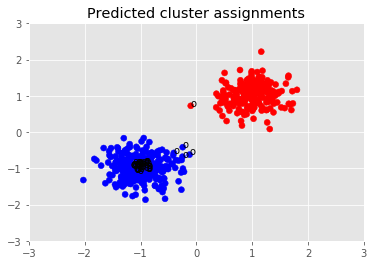

In [22]:
num_top_pdis = 50
largest_pdis = pdi_values.argsort()[-num_top_pdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_pdis): 
    plt.text(x_train[largest_pdis[i]][0],x_train[largest_pdis[i]][1] , "o", fontsize=10)
plt.show()

### WAPDI definition

In [23]:
#p_x_given_theta_2 = tf.matmul(tf.exp(log_liks2), pi_samples_tiled)
#p_x_given_theta_2 = tf.reshape(tf.log(p_x_given_theta), [N, -1])
#mean_2, variance_2 = tf.nn.moments(p_x_given_theta_2, axes=[1])  #此处mean实现有误 原式是log mu(n)
#wapdi = tf.div(variance_2, mean_2)

In [24]:
#wapdi_values = sess.run(wapdi)

In [25]:
_, wapdi_variance = tf.nn.moments(edited_log_sum_3, axes=[1])
wapdi_log_mean = tf.log(pdi_mean)
wapdi = tf.divide(wapdi_variance, wapdi_log_mean)
wapdi_values = sess.run(wapdi)

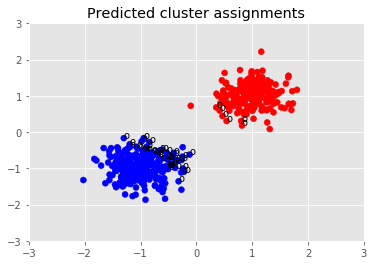

In [30]:
num_top_wapdis = 50
largest_wapdis = wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=10)
plt.show()

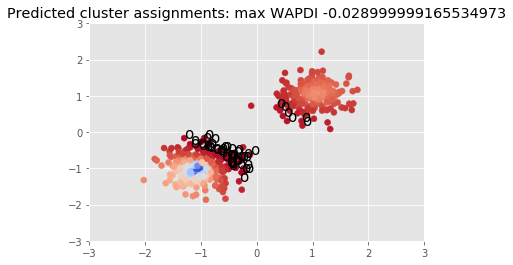

In [31]:
num_top_wapdis = 50
largest_wapdis = wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=wapdi_values, cmap=plt.cm.coolwarm)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: max WAPDI {}".format(round(wapdi_values[largest_wapdis[0]], 3)))
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=15)
    
plt.show()

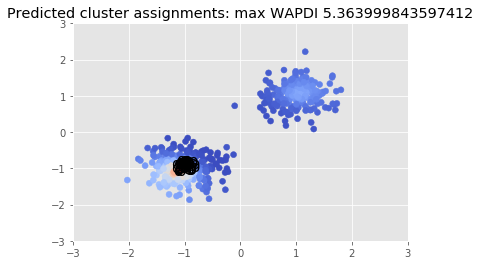

In [33]:
# we look at absolute value here
num_top_wapdis = 50
largest_wapdis = np.abs(wapdi_values).argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=np.abs(wapdi_values), cmap=plt.cm.coolwarm)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: max WAPDI {}".format(round(np.abs(wapdi_values)[largest_wapdis[0]], 3)))
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=15)
    
plt.show()

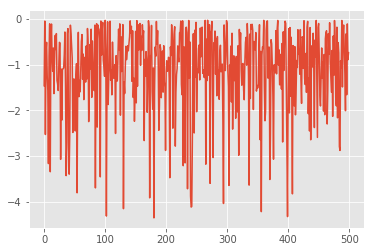

In [66]:
plt.plot(wapdi_values)

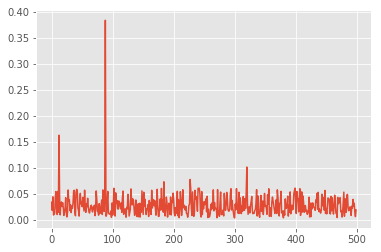

In [67]:
plt.plot(pdi_values)